In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import scipy
import random 
import pickle
import os
import time
from statsmodels.regression.linear_model import OLS
from scipy.optimize import minimize

random.seed(123)
np.random.seed(123)

## Load Stock Data

In [6]:
with open(b"ret.p","rb") as f:
    ret= pickle.load(f)
with open(b"factors.p","rb") as f:
    df_ff5 = pickle.load(f)
with open(b"close.p","rb") as f:
    close = pickle.load(f)
with open(b"stock_data.p","rb") as f:
    stock_data = pickle.load(f)

## Set Prior

In [ ]:
K = df_ff5.shape[1]
T, M = ret.shape
zeros = np.zeros(K)
beta_prior = {'B_0': np.zeros((M,K)) , 'g': 10}
mu_f_prior=  {'mu_0': zeros, 'tau': 1}
F_prior = {'d_0': 1, 'F_0': np.identity(K)*0.000223}
sigma_prior = {'v0': 1, 'sigma02': 0.0005}

prior = {
    'B': beta_prior,
    'mu_f': mu_f_prior,
    'F': F_prior,
    'sigma2': sigma_prior}


Compute Mean & Covariance

In [ ]:
def analytical_predictive_mean_cov(rt, ft, prior):
    # dimensions
    T, M = rt.shape
    K = ft.shape[1]
    
    # Prior
    mu_0 = prior['mu_f']['mu_0']
    tau = prior['mu_f']['tau']
    d_0 = prior['F']['d_0']
    F_0 = prior['F']['F_0']
    B_0 = prior['B']['B_0']
    g = prior['B']['g']
    v_0 = prior['sigma2']['v0']
    sigma02 = prior['sigma2']['sigma02']
    
    # Common variables
    f_bar = ft.mean(axis=0)
    FTF = ft.T.dot(ft)
    FTFinv = np.linalg.inv(FTF)
    B_ols = FTFinv.dot(ft.T).dot(rt).T
    
    ## E[muf]
    E_muf = tau / (tau + T) * mu_0 + T / (tau + T) * f_bar
    
    ## E[B]
    E_B = g / (g+1) * (B_ols + B_0 / g)
    
    ## E[r]
    E_r = E_muf.dot(E_B.T)
    
    # Covariance
    ## E[sigmas2] & Var(B_m)
    Var_Bm = np.zeros((M, K,K))
    E_sigmas2 = np.zeros(M)
    beta0FTFbeta0 = [B_0[m, :].T.dot(FTF).dot(B_0[m, :]) for m in range(M)]
    for m in range(M):
        r = rt[:, m]
        beta_0 = B_0[m, :]
        beta_ols = B_ols[m, :]
        
        r_min_FBols = r - ft.dot(beta_ols)
        beta_diff = beta_ols - beta_0
        SSR_g = r_min_FBols.T.dot(r_min_FBols) + (beta_diff.T.dot(FTF).dot(beta_diff)) / (g+1)
        
        alpha = (v_0 + T) / 2 
        beta = (v_0 * sigma02 + SSR_g) / 2 
        E_sigmas2[m] = beta / (alpha-1) 
        Var_Bm[m, :, :]= g/(g+1) * (v_0 * sigma02 + SSR_g) / (v_0 + T) * FTFinv * (v_0 + T) / (v_0 + T - 2)
        
    ## E[F]
    d_n = d_0 + T
    dof = d_n - K + 1
    F_min_fbar = np.add(ft, -f_bar)
    F_min_mu0 = np.add(f_bar, -mu_0)
    Lambda_n = F_0 + F_min_fbar.T.dot(F_min_fbar) + np.outer(F_min_mu0, F_min_mu0) * (tau * T) * (tau + T)
    E_F = Lambda_n / (d_n - K - 1)
    
    ## Var(muf)
    Var_muf = Lambda_n / (tau + T) / dof
    
    ## Var(r)
    # diagonal
    Var_r = np.zeros((M, M))
    Var_r = Var_r + np.diag(E_sigmas2)
    E_ffT = E_F + Var_muf + np.outer(E_muf, E_muf)
    Var_f = E_F + Var_muf
    for m in range(M):
        E_Bm = E_B[m, :]
        Var_r[m,m] = Var_r[m,m] + np.trace(E_ffT.dot(Var_Bm[m, :, :])) + E_Bm.T.dot(Var_f).dot(E_Bm)
        
    # covariance
    for i in range(1, M):
        E_Bi = E_B[i, :]
        for j in range(i):
            E_Bj = E_B[j, :]
            Var_r[i,j] = E_Bi.T.dot(Var_f).dot(E_Bj)
            Var_r[j,i] = Var_r[i,j]
            
    return E_r, Var_r

            

## Compute Optimal Portfolios

In [ ]:
def unconstrained_opt(mean, cov, m=4):
    cov_inv = np.linalg.inv(cov)
    ones = np.ones(cov.shape[0])
    v = (2*m- ones.T.dot(cov_inv).dot(mean))/ ones.T.dot(cov_inv).dot(ones)
    w = (cov_inv.dot(mean + v*ones)) / (2*m)
    # w = w/np.abs(w).sum()
    return w

def efficient_frontier_without_budget(mean, cov, target_mean):
    cov_inv = np.linalg.inv(cov)
    cov_inv_dot_mean = cov_inv.dot(mean)
    w = (cov_inv_dot_mean*target_mean) / (mean.T.dot(cov_inv_dot_mean))
    # w = w/np.abs(w).sum()
    return w

def efficient_frontier_with_budget(mean, cov, target_mean):
    cov_inv = np.linalg.inv(cov)
    ones = np.ones(cov.shape[0])
    ones_dot_cov_inv = ones.T.dot(cov_inv)
    mean_dot_cov_inv = mean.T.dot(cov_inv)
    d = ones_dot_cov_inv.dot(ones) * mean_dot_cov_inv.dot(mean) - (ones_dot_cov_inv.dot(mean))**2
    e = (ones * target_mean - mean) / d
    b = -mean_dot_cov_inv.dot(e)
    a = ones_dot_cov_inv.dot(e)
    w = cov_inv.dot(a * mean + b * ones)
    # w = w/np.abs(w).sum()
    return w

def minium_var(mean, cov):
    cov_inv = np.linalg.inv(cov)
    ones = np.ones(cov_inv.shape[0])
    cov_inv_dot_one = cov_inv.dot(ones)
    w = (1/ones.T.dot(cov_inv_dot_one)) * cov_inv_dot_one
    # w = w/np.abs(w).sum()
    return w

### Marginal Likelihood and g*

In [ ]:
def negative_loglikelihood(g, rt, ft, B_0, B_ols, v0, sigma02):
    T, M = rt.shape
    T, K = ft.shape
    
    sum_loglikelihood = 0
    FTF = ft.T.dot(ft)
    for m in range(M):
        beta_ols = B_ols[m, :]
        beta_0 = B_0[m, :]
        rm = rt[:, m]
        
        r_min_FBols = rm - ft.dot(beta_ols)
        beta_diff = beta_ols - beta_0
        SSR_g = r_min_FBols.T.dot(r_min_FBols) + (beta_diff.T.dot(FTF).dot(beta_diff)) / (g+1)
        
        loglike_m = -K/2*np.log(1+g) - (v0+T)/2 * np.log(SSR_g + v0*sigma02)
        sum_loglikelihood += loglike_m
    return -sum_loglikelihood


def best_g(rt, ft, prior):
    FTF = ft.T.dot(ft)
    FTFinv = np.linalg.inv(FTF)
    B_ols = FTFinv.dot(ft.T).dot(rt).T
    B_0 = prior['B']['B_0']
    v0 = prior['sigma2']['v0']
    sigma02 = prior['sigma2']['sigma02']
    
    bnds = ((0.001, None),)
    return minimize(negative_loglikelihood, np.array([1]), args=(rt, ft, B_0, B_ols, v0, sigma02), bounds=bnds).x[0]

# Backtest Strategies

In [1838]:
def backtest_stat(mod_res, sam_res, mod_turnover, sample_turnover, txn_cost = 0.06 / 100):
    sharpe_df = pd.DataFrame(mod_res.mean() / mod_res.std() * np.sqrt(251), columns=['Model']).join(pd.DataFrame(sam_res.mean() / sam_res.std() * np.sqrt(251), columns=['Sample']))
    sharpe_df = sharpe_df[~sharpe_df.index.str.contains("WOB")]
    
    turnover_df = pd.DataFrame(mod_turnover, columns=['Model'], index=mod_res.columns).join( pd.DataFrame(sample_turnover, columns=['Sample'], index=sam_res.columns))
    turnover_df = turnover_df[~turnover_df.index.str.contains("WOB")]
    
    vol_df = pd.DataFrame(mod_res.std() * np.sqrt(251), columns=['Model']).join(pd.DataFrame(sam_res.std() * np.sqrt(251), columns=['Sample']))
    vol_df = vol_df[~vol_df.index.str.contains("WOB")]
    
    txn_sharpe_df = pd.DataFrame((mod_res.mean() - mod_turnover *txn_cost) / mod_res.std() * np.sqrt(251), columns=['Model']).join(pd.DataFrame((sam_res.mean() - sample_turnover * txn_cost) / sam_res.std() * np.sqrt(251), columns=['Sample']))
    txn_sharpe_df = txn_sharpe_df[~txn_sharpe_df.index.str.contains("WOB")]

    return sharpe_df, turnover_df, vol_df, txn_sharpe_df

def backtest(ret, ft, prior, lookback_period):    
    prior = prior.copy()
    T, M = ret.shape
    K = ft.shape[1]
    ret_views = np.lib.stride_tricks.sliding_window_view(ret, (lookback_period+1, M))
    ft_views = np.lib.stride_tricks.sliding_window_view(ft, (lookback_period+1, K))
    
    model_return = list()
    sample_return = list()
    target_mean = [0.0003,  0.0005,  0.0007,  0.0009, 0.0012, 0.0015]
    
    model_last_w = np.ones((1+len(target_mean)*2, M)) / M
    model_turnover = np.zeros((1+len(target_mean)*2))
    
    sample_last_w = np.ones((1+len(target_mean)*2, M)) / M
    sample_turnover = np.zeros((1+len(target_mean)*2))
    
    mean_difference = np.zeros(ret_views.shape[0])
    cov_difference = np.zeros(ret_views.shape[0])
    
    g_history = np.zeros(ret_views.shape[0])
    model_w_diff_history = np.zeros((1+len(target_mean)*2, ret_views.shape[0], M))
    
    for i in range(ret_views.shape[0]):
        if i%100==0:
            print('{}: -----'.format(i))
            
        ret_view = ret_views[i][0]
        ft_view = ft_views[i][0]
        
        train_ret = ret_view[:-1, :]
        train_ft = ft_view[:-1, :]
        test_ret = ret_view[-1, :]

        port_vals = list()
        
        # ------ Best g -------
        prior['B']['B_0'] = np.zeros((M,K))
        prior['B']['g'] = np.round(best_g(train_ret, train_ft, prior),2)
        g_history[i] = prior['B']['g']

        # ------ Model -------
        turnover_id = 0
        mean, cov = analytical_predictive_mean_cov(train_ret, train_ft, prior=prior)
        # -------------------------------
        # temporary for comparison
        mean_dif = np.abs(mean  / train_ret.mean(axis=0) -1)
        mean_dif = np.mean(mean_dif[~np.isinf(mean_dif)])
        mean_difference[i] = mean_dif
        
        cov_dif =np.abs(cov  / np.cov(train_ret.T) -1)
        cov_dif = np.mean(cov_dif[~np.isinf(cov_dif)])
        cov_difference[i] = cov_dif
        # --------------------------------
        port_w = minium_var(mean, cov)
        port_vals.append(port_w.T.dot(test_ret))
        model_turnover[turnover_id] = model_turnover[turnover_id] + np.sum(np.abs(port_w - model_last_w[turnover_id, :]))
        model_last_w[turnover_id, :] = port_w
        model_w_diff_history[turnover_id, i, :] = port_w
        turnover_id += 1
        
        for m in target_mean:
            port_w = efficient_frontier_with_budget(mean, cov, target_mean=m)
            port_vals.append(port_w.T.dot(test_ret))
            model_turnover[turnover_id] = model_turnover[turnover_id] + np.sum(np.abs(port_w - model_last_w[turnover_id, :]))
            model_last_w[turnover_id, :] = port_w
            model_w_diff_history[turnover_id, i, :] = port_w
            turnover_id += 1
            
            port_w = efficient_frontier_without_budget(mean, cov, target_mean=m)
            port_vals.append(port_w.T.dot(test_ret))
            model_turnover[turnover_id] = model_turnover[turnover_id] + np.sum(np.abs(port_w - model_last_w[turnover_id, :]))
            model_last_w[turnover_id, :] = port_w
            model_w_diff_history[turnover_id, i, :] = port_w
            turnover_id += 1
            
        model_return.append(port_vals)
        
        port_vals = list()
        # ------ Sample -------
        turnover_id = 0
        mean, cov = train_ret.mean(axis=0), np.cov(train_ret.T)
        
        port_w = minium_var(mean, cov)
        port_vals.append(port_w.T.dot(test_ret))
        sample_turnover[turnover_id] = sample_turnover[turnover_id] + np.sum(np.abs(port_w - sample_last_w[turnover_id, :]))
        sample_last_w[turnover_id, :] = port_w
        model_w_diff_history[turnover_id, i, :] = model_w_diff_history[turnover_id, i, :] - port_w
        turnover_id += 1
        
        col_names = ['MV']
        for m in target_mean:
            col_names += ['WB({})'.format(m), 'WOB({})'.format(m)]
            port_w = efficient_frontier_with_budget(mean, cov, target_mean=m)
            port_vals.append(port_w.T.dot(test_ret))
            sample_turnover[turnover_id] = sample_turnover[turnover_id] + np.sum(np.abs(port_w - sample_last_w[turnover_id, :]))
            sample_last_w[turnover_id, :] = port_w
            model_w_diff_history[turnover_id, i, :] = model_w_diff_history[turnover_id, i, :] - port_w
            turnover_id += 1
            
            port_w = efficient_frontier_without_budget(mean, cov, target_mean=m)
            port_vals.append(port_w.T.dot(test_ret))
            sample_turnover[turnover_id] = sample_turnover[turnover_id] + np.sum(np.abs(port_w - sample_last_w[turnover_id, :]))
            sample_last_w[turnover_id, :] = port_w
            model_w_diff_history[turnover_id, i, :] = model_w_diff_history[turnover_id, i, :] - port_w
            turnover_id += 1
            
        sample_return.append(port_vals)
        # print('Sample: {}'.format(port_vals))
    
    mod_res =  pd.DataFrame(model_return, columns=col_names)
    sam_res = pd.DataFrame(sample_return, columns=col_names)
    mod_turnover = model_turnover/ret_views.shape[0]
    sample_turnover = sample_turnover  /ret_views.shape[0]
    return backtest_stat(mod_res, sam_res, mod_turnover, sample_turnover), mean_difference, cov_difference, g_history, model_w_diff_history,  mod_res, sam_res


In [ ]:
package_base = backtest(ret.values, df_ff5.values, prior, lookback_period=251)

# Poster graph

Text(0, 0.5, 'Cumulative return')

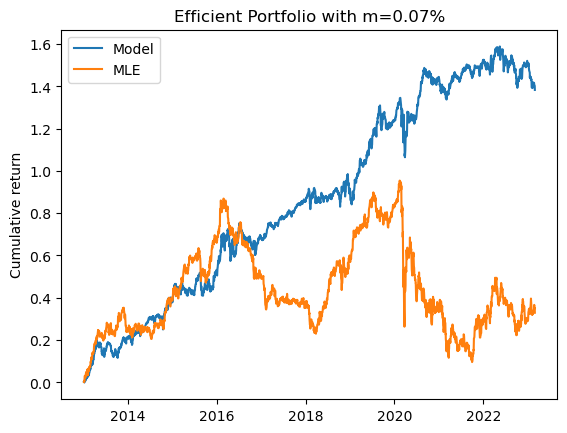

In [1831]:
plt.plot(ret.index[-2555:], package_base[-2]['WB(0.0007)'].cumsum())
plt.plot(ret.index[-2555:], package_base[-1]['WB(0.0007)'].cumsum())
plt.legend(['Model', 'MLE'])
plt.title('Efficient Portfolio with m=0.07%')
plt.ylabel('Cumulative return')

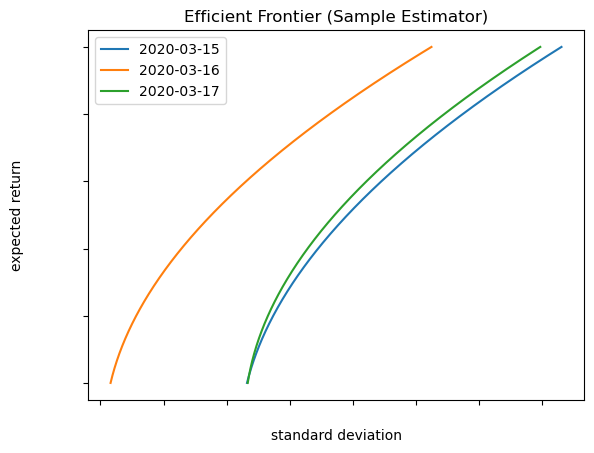

In [1818]:
dates = ['2020-03-15', '2020-03-16', '2020-03-17']

def efficient_frontier(mean, cov):
    m = np.linspace(0, 0.001, 500)
    std = np.zeros(len(m))
    
    for i in range(len(m)):
        m_val = m[i]
        w = efficient_frontier_with_budget(mean, cov, m_val)
        std[i] = np.sqrt(w.T.dot(cov).dot(w))
    return m, std

for d in dates:
    date_ret = ret.loc[(ret.index <= pd.to_datetime(d))].iloc[-251:, :]
    date_ff = df_ff5.loc[(df_ff5.index <= pd.to_datetime(d))].iloc[-251:, :]
    mean, cov = date_ret.mean(axis=0), np.cov(date_ret.T)
    m, std = efficient_frontier(mean, cov)
    plt.plot(std, m)
plt.legend(dates)
plt.title('Efficient Frontier (Sample Estimator)')
plt.xlabel('standard deviation')
plt.ylabel('expected return')
plt.xticks(color='white')
plt.yticks(color='white');

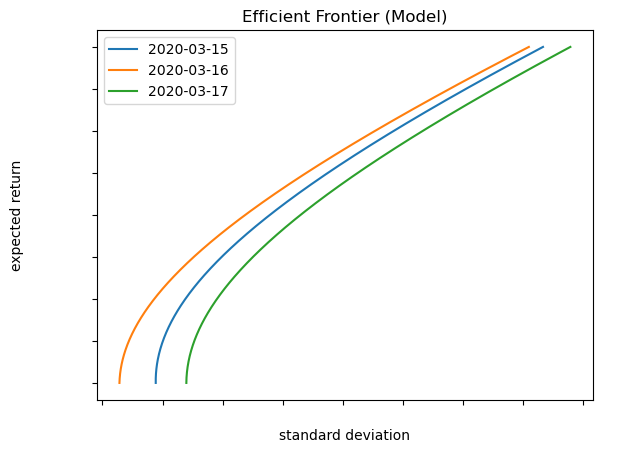

In [1819]:
dates = ['2020-03-15', '2020-03-16', '2020-03-17']

def efficient_frontier(mean, cov):
    m = np.linspace(0, 0.0004, 500)
    std = np.zeros(len(m))
    
    for i in range(len(m)):
        m_val = m[i]
        w = efficient_frontier_with_budget(mean, cov, m_val)
        std[i] = np.sqrt(w.T.dot(cov).dot(w))
    return m, std

for d in dates:
    date_ret = ret.loc[(ret.index <= pd.to_datetime(d))].iloc[-251:, :]
    date_ff = df_ff5.loc[(df_ff5.index <= pd.to_datetime(d))].iloc[-251:, :]
    
    prior['B']['B0'] = np.zeros((200,5)) 
    g_opt = best_g(date_ret.values, date_ff.values, prior)
    prior['B']['g'] = g_opt
    mod_m, mod_std = efficient_frontier(*analytical_predictive_mean_cov(date_ret.values, date_ff.values, prior))
    
    plt.plot(mod_std, mod_m)
plt.legend(dates)
plt.title('Efficient Frontier (Model)')
plt.xlabel('standard deviation')
plt.ylabel('expected return')
plt.xticks(color='white')
plt.yticks(color='white');

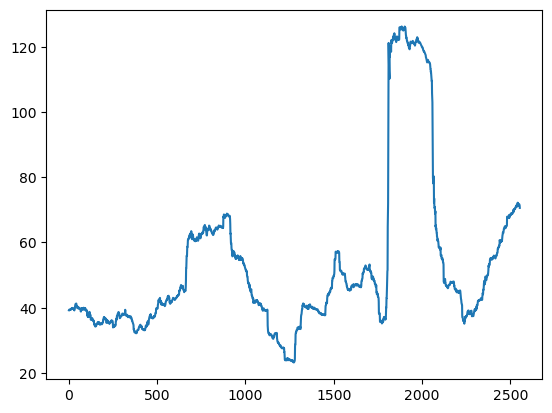

In [1834]:
plt.plot(package_base[-4])